# PEEWEE ORM

Here I will demonstrate how to use PEEWEE ORM to get the world bank data into a database. 

In [1]:
from peewee import * 
from playhouse.postgres_ext import PostgresqlDatabase

import pandas as pd

from tqdm import tqdm
from os.path import join 

from time import sleep

from IPython import display
import matplotlib.pyplot as pl 
import seaborn as sns

%matplotlib inline

In [2]:
db = PostgresqlDatabase('ads')

class BaseModel(Model):
    class Meta:
        database = db

class Country(BaseModel): 
    id = PrimaryKeyField()
    
    name = CharField()
    
class LifeExpectancy(BaseModel):
    id = PrimaryKeyField()
    
    country = ForeignKeyField(
        Country, 
        index=True, 
        null=False, 
        related_name='life_expectancy', 
        on_delete='cascade'
    )
    
    year = IntegerField(null=False)
    value = FloatField(null=True)
    
class Population(BaseModel):
    id = PrimaryKeyField()
    
    country = ForeignKeyField(
        Country, 
        index=True, 
        null=False, 
        related_name='population', 
        on_delete='cascade'
    )
    
    year = IntegerField(null=False)
    value = FloatField(null=True)
    
class GDP(BaseModel):
    id = PrimaryKeyField()
    
    country = ForeignKeyField(
        Country, 
        index=True, 
        null=False, 
        related_name='gdp', 
        on_delete='cascade'
    )
    
    year = IntegerField(null=False)
    value = FloatField(null=True)
    
models = [
    Country, 
    LifeExpectancy, 
    Population, 
    GDP, 
]

In [3]:
def rearrange_dataframe(df, indicator_name):
    country = 'Country Name'
    years = [c for c in df.columns if c[0] == '1' or c[0] == '2']
    df = pd.melt(df[[country] + years], id_vars=country, var_name='year')
    df.rename(columns={'value': indicator_name}, inplace=True)
    return df

db.drop_tables(models, safe=True, cascade=True)
db.create_tables(models, safe=True)

sources = [
    ('API_SP.DYN.LE00.IN_DS2_en_csv_v2_713010', 'Life expectency at birth', LifeExpectancy),
    ('API_SP.POP.TOTL_DS2_en_csv_v2_713131',    'Total population',         Population    ),
    ('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_713080', 'GDP per capita',           GDP           ),
]

for source, key, model in sources: 
    df = rearrange_dataframe(pd.read_csv(join(source, '{}.csv'.format(source)), skiprows=4), key)
    print(df.head())
    
    for ri, row in tqdm(df.iterrows()):
        country, inserted = Country.get_or_create(name=row['Country Name'])
        
        model.create(
            country=country, 
            year=int(row['year']), 
            value=row[key]
        )
        
        # For faster insersion, the insert_many method may be used. 

13it [00:00, 122.36it/s]

  Country Name  year  Life expectency at birth
0        Aruba  1960                    65.662
1  Afghanistan  1960                    32.446
2       Angola  1960                    37.524
3      Albania  1960                    62.283
4      Andorra  1960                       NaN


15840it [01:03, 250.28it/s]
32it [00:00, 317.95it/s]

  Country Name  year  Total population
0        Aruba  1960           54211.0
1  Afghanistan  1960         8996973.0
2       Angola  1960         5454933.0
3      Albania  1960         1608800.0
4      Andorra  1960           13411.0


15840it [01:02, 252.98it/s]
44it [00:00, 432.96it/s]

  Country Name  year  GDP per capita
0        Aruba  1960             NaN
1  Afghanistan  1960       59.773194
2       Angola  1960             NaN
3      Albania  1960             NaN
4      Andorra  1960             NaN


15840it [01:06, 236.83it/s]


In [5]:
#GDP.select().count()
print(GDP.select())
#type(lq[0])
#lq[0].value
#lq[0]

SELECT "t1"."id", "t1"."country_id", "t1"."year", "t1"."value" FROM "gdp" AS "t1"


In [6]:
q = GDP.select().limit(10)

print(q)

lq = list(q)
print(lq)
print(lq[0])
print(lq[0].country.name)

SELECT "t1"."id", "t1"."country_id", "t1"."year", "t1"."value" FROM "gdp" AS "t1" LIMIT 10
[<GDP: 1>, <GDP: 2>, <GDP: 3>, <GDP: 4>, <GDP: 5>, <GDP: 6>, <GDP: 7>, <GDP: 8>, <GDP: 9>, <GDP: 10>]
1
Aruba


In [8]:
c1 = Country.select().where(Country.id == 110).get()

c1.name

'Ireland'

In [9]:
list(Population.select().dicts())

[{'id': 1, 'country': 1, 'year': 1960, 'value': 54211.0},
 {'id': 2, 'country': 2, 'year': 1960, 'value': 8996970.0},
 {'id': 3, 'country': 3, 'year': 1960, 'value': 5454930.0},
 {'id': 4, 'country': 4, 'year': 1960, 'value': 1608800.0},
 {'id': 5, 'country': 5, 'year': 1960, 'value': 13411.0},
 {'id': 6, 'country': 6, 'year': 1960, 'value': 92197800.0},
 {'id': 7, 'country': 7, 'year': 1960, 'value': 92418.0},
 {'id': 8, 'country': 8, 'year': 1960, 'value': 20481800.0},
 {'id': 9, 'country': 9, 'year': 1960, 'value': 1874120.0},
 {'id': 10, 'country': 10, 'year': 1960, 'value': 20123.0},
 {'id': 11, 'country': 11, 'year': 1960, 'value': 54131.0},
 {'id': 12, 'country': 12, 'year': 1960, 'value': 10276500.0},
 {'id': 13, 'country': 13, 'year': 1960, 'value': 7047540.0},
 {'id': 14, 'country': 14, 'year': 1960, 'value': 3895400.0},
 {'id': 15, 'country': 15, 'year': 1960, 'value': 2797930.0},
 {'id': 16, 'country': 16, 'year': 1960, 'value': 9153490.0},
 {'id': 17, 'country': 17, 'year'

In [ ]:
db.rollback()

In [10]:
list(Country.select(
    Country.name, 
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
).where(
    Country.id == 110
).join(
    GDP, 
    on=Country.id == GDP.country_id
).join(
    Population, 
    on=(Country.id == Population.country_id) & (GDP.year == Population.year)
).dicts())

[{'name': 'Ireland', 'year': 1960, 'gdp': 685.615, 'pop': 2828600.0},
 {'name': 'Ireland', 'year': 1961, 'gdp': 739.276, 'pop': 2824400.0},
 {'name': 'Ireland', 'year': 1962, 'gdp': 797.006, 'pop': 2836050.0},
 {'name': 'Ireland', 'year': 1963, 'gdp': 852.135, 'pop': 2852650.0},
 {'name': 'Ireland', 'year': 1964, 'gdp': 965.135, 'pop': 2866550.0},
 {'name': 'Ireland', 'year': 1965, 'gdp': 1023.77, 'pop': 2877300.0},
 {'name': 'Ireland', 'year': 1966, 'gdp': 1074.51, 'pop': 2888800.0},
 {'name': 'Ireland', 'year': 1967, 'gdp': 1152.01, 'pop': 2902450.0},
 {'name': 'Ireland', 'year': 1968, 'gdp': 1124.52, 'pop': 2915550.0},
 {'name': 'Ireland', 'year': 1969, 'gdp': 1291.35, 'pop': 2932650.0},
 {'name': 'Ireland', 'year': 1970, 'gdp': 1488.29, 'pop': 2957250.0},
 {'name': 'Ireland', 'year': 1971, 'gdp': 1705.97, 'pop': 2992050.0},
 {'name': 'Ireland', 'year': 1972, 'gdp': 2082.96, 'pop': 3036850.0},
 {'name': 'Ireland', 'year': 1973, 'gdp': 2427.17, 'pop': 3085950.0},
 {'name': 'Ireland',

In [11]:
list(Country.select(
    Country.name, 
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
).where(
    Country.id == 110
).join(
    GDP, 
    on=Country.id == GDP.country_id
).join(
    Population, 
    on=(Country.id == Population.country_id) & (GDP.year == Population.year)
).limit(10).dicts())

[{'name': 'Ireland', 'year': 1960, 'gdp': 685.615, 'pop': 2828600.0},
 {'name': 'Ireland', 'year': 1961, 'gdp': 739.276, 'pop': 2824400.0},
 {'name': 'Ireland', 'year': 1962, 'gdp': 797.006, 'pop': 2836050.0},
 {'name': 'Ireland', 'year': 1963, 'gdp': 852.135, 'pop': 2852650.0},
 {'name': 'Ireland', 'year': 1964, 'gdp': 965.135, 'pop': 2866550.0},
 {'name': 'Ireland', 'year': 1965, 'gdp': 1023.77, 'pop': 2877300.0},
 {'name': 'Ireland', 'year': 1966, 'gdp': 1074.51, 'pop': 2888800.0},
 {'name': 'Ireland', 'year': 1967, 'gdp': 1152.01, 'pop': 2902450.0},
 {'name': 'Ireland', 'year': 1968, 'gdp': 1124.52, 'pop': 2915550.0},
 {'name': 'Ireland', 'year': 1969, 'gdp': 1291.35, 'pop': 2932650.0}]

In [12]:
df = pd.DataFrame(list(Country.select(
    Country.name, 
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
    LifeExpectancy.value.alias('le'),
).where(
    Country.id == 110
).join(
    GDP, 
    on=Country.id == GDP.country_id
).join(
    Population, 
    on=(Country.id == Population.country_id) & (GDP.year == Population.year)
).join(
    LifeExpectancy, 
    on=(Country.id == LifeExpectancy.country_id) & (GDP.year == LifeExpectancy.year)
).dicts()))
df.set_index('year', inplace=True)
del df['name']

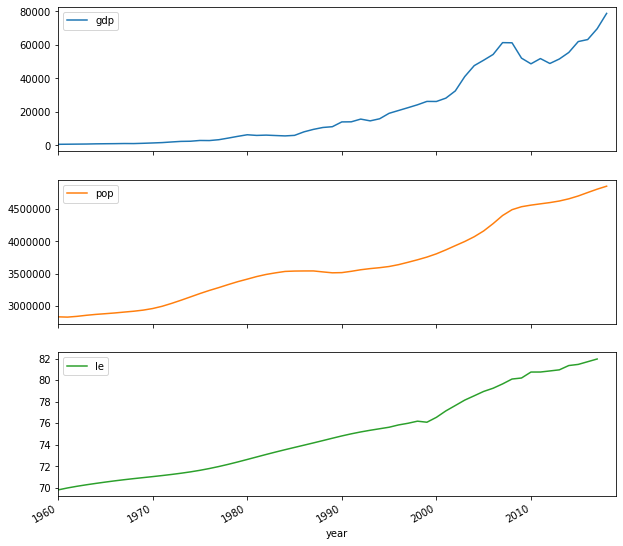

In [13]:
df.plot(subplots=True, figsize=(10,10));

In [14]:
c = Country.select(
    Country.name, 
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
    LifeExpectancy.value.alias('le'),
).where(
    Country.id == 59
).join(
    GDP, 
    on=Country.id == GDP.country_id
).join(
    Population, 
    on=(Country.id == Population.country_id) & (GDP.year == Population.year)
).join(
    LifeExpectancy, 
    on=(Country.id == LifeExpectancy.country_id) & (GDP.year == LifeExpectancy.year)
)

In [15]:
cur = db.cursor()
print(cur.mogrify(*c.sql()))

b'SELECT "t1"."name", "t2"."year", "t2"."value" AS "gdp", "t3"."value" AS "pop", "t4"."value" AS "le" FROM "country" AS "t1" INNER JOIN "gdp" AS "t2" ON ("t1"."id" = "t2"."country_id") INNER JOIN "population" AS "t3" ON (("t1"."id" = "t3"."country_id") AND ("t2"."year" = "t3"."year")) INNER JOIN "lifeexpectancy" AS "t4" ON (("t1"."id" = "t4"."country_id") AND ("t2"."year" = "t4"."year")) WHERE ("t1"."id" = 59)'


In [16]:
df = pd.DataFrame(list(GDP.select(
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
    LifeExpectancy.value.alias('le'),
).join(
    Population, 
    on=(GDP.year == Population.year) & (GDP.country_id == Population.country_id)
).join(
    LifeExpectancy, 
    on=(GDP.year == LifeExpectancy.year) & (GDP.country_id == LifeExpectancy.country_id)
).join(
    Country, 
    on=GDP.country_id == Country.id
).where(
    Country.name == 'United Kingdom'
).dicts()))

df.set_index('year', inplace=True)
df.head()

,gdp,pop,le
year,,,
1960,1397.59,52400000.0,71.1268
1961,1472.39,52800000.0,70.8781
1962,1525.78,53250000.0,70.9268
1963,1613.46,53650000.0,70.8268
1964,1748.29,54000000.0,71.6244


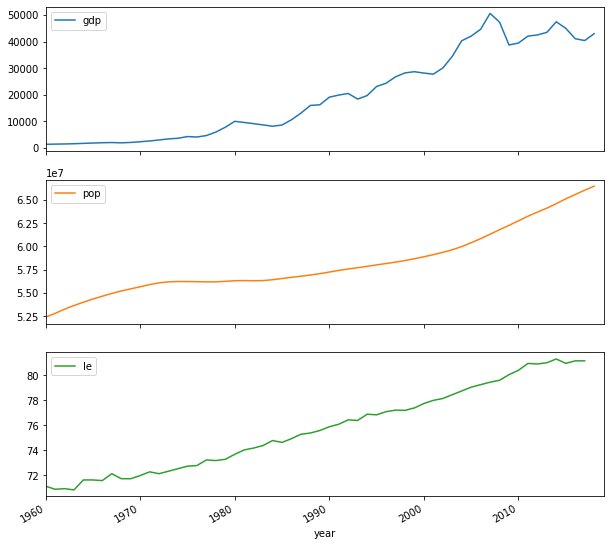

In [17]:
df.plot(subplots=True, figsize=(10, 10));

In [18]:
df = pd.DataFrame(list(GDP.select(
    Country.name.alias('country'),
    GDP.year,
    GDP.value.alias('gdp'),
    Population.value.alias('pop'),
    LifeExpectancy.value.alias('le'),
).join(
    Population, 
    on=(GDP.year == Population.year) & (GDP.country_id == Population.country_id)
).join(
    LifeExpectancy, 
    on=(GDP.year == LifeExpectancy.year) & (GDP.country_id == LifeExpectancy.country_id)
).join(
    Country, 
    on=GDP.country_id == Country.id
).dicts()))

df.head()

,country,year,gdp,pop,le
0,Aruba,1960,NaN,54211.0,65.662
1,Aruba,1961,NaN,55438.0,66.074
2,Aruba,1962,NaN,56225.0,66.444
3,Aruba,1963,NaN,56695.0,66.787
4,Aruba,1964,NaN,57032.0,67.113


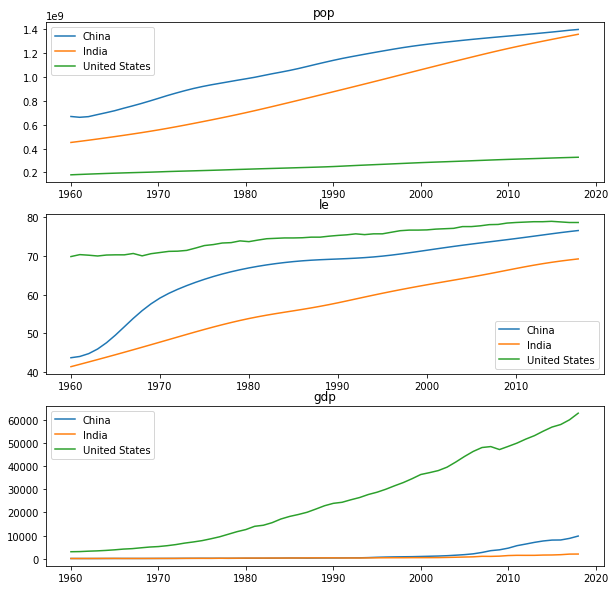

In [19]:
countries = {
    'United States', 
    'China',  
    'India'
}

keys = ('pop', 'le', 'gdp')

fig, axes = pl.subplots(3, 1, figsize=(10, 10))

for country, group in df.groupby('country'): 
    if country in countries: 
        for ax, key in zip(axes, keys):
            ax.plot(group.year, group[key], label=country)
            
for ax, key in zip(axes, keys): 
    pl.sca(ax)
    pl.title(key)
    pl.legend()

In [20]:
df.describe()

,year,gdp,pop,le
count,15840.000000,12057.000000,1.540900e+04,13997.000000
mean,1989.500000,7624.946187,2.078865e+08,63.700224
std,17.318649,15255.156074,6.867796e+08,11.188258
min,1960.000000,34.790600,3.893000e+03,18.907000
25%,1974.750000,502.757000,9.268410e+05,55.606000
50%,1989.500000,1760.310000,6.418770e+06,66.479200
75%,2004.250000,7152.380000,4.244900e+07,72.144000
max,2019.000000,189171.000000,7.594270e+09,85.417100


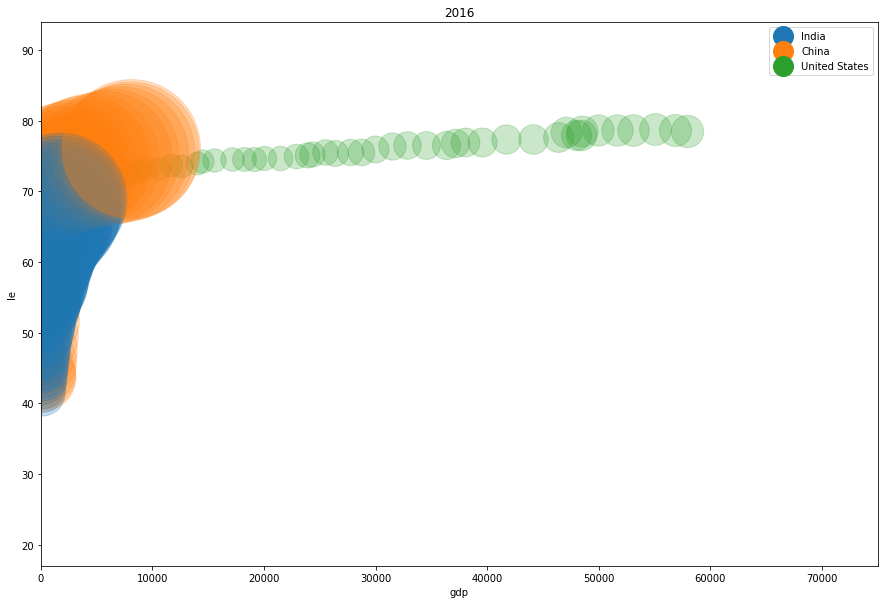

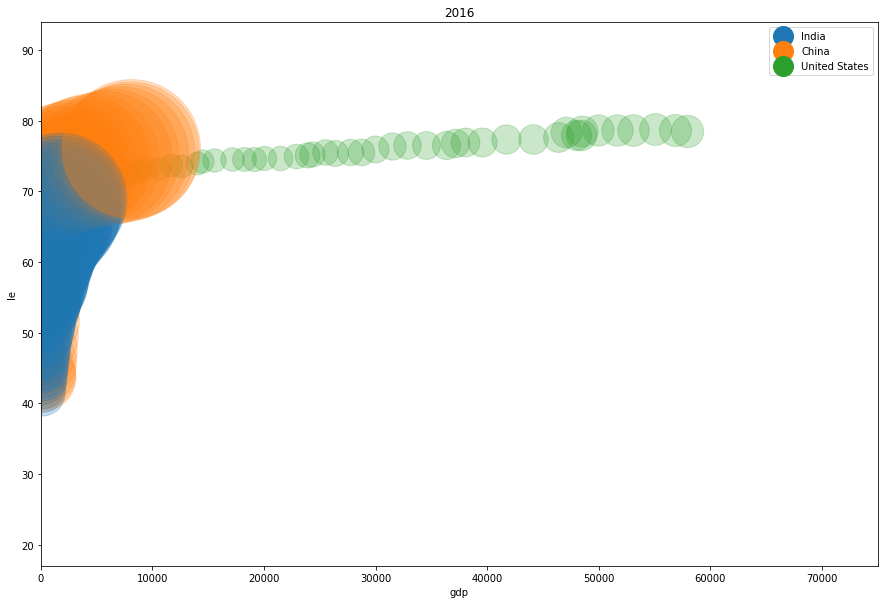

In [21]:
x = 'gdp'# per capita'
y = 'le'
s = 'pop'
do_legend = True

def pw_scatter(df, year):
    current_palette = sns.color_palette()
    alpha = 0.25
    for i, c in enumerate(countries):
        country = Country.select().where(Country.name == c).get()
        gdp = GDP.select().where(GDP.country_id == country, GDP.year == year).get()
        pop = Population.select().where(Population.country_id == country, Population.year == year).get()
        le = LifeExpectancy.select().where(LifeExpectancy.country_id == country, LifeExpectancy.year == year).get()
        ax.plot(gdp.value, le.value, marker='o', linestyle='', color=current_palette[i], ms=pop.value / 1e7, label=c, alpha=alpha)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim([0, 75000])
    ax.set_ylim([df[y].min()*0.9, df[y].max()*1.1])
    ax.set_title(year)

# Animated version
fig, ax = pl.subplots(figsize=[15 ,10])
#countries = ['United Kingdom', 'France', 'Germany']

for year in range(1960, 2017):
    pw_scatter(df, year)

    if do_legend:
        lgnd = ax.legend()
        for i in range(len(countries)):
            lgnd.legendHandles[i]._legmarker.set_markersize(20)
            lgnd.legendHandles[i]._legmarker.set_alpha(1.0)
        do_legend = False

    display.clear_output(wait=True)
    display.display(pl.gcf())
    sleep(0.02)